In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from sklearn.model_selection import train_test_split

X_numpy = np.random.randn(1000, 10)
y_numpy = np.random.randint(0, 2, 1000)

X_train, X_val, y_train, y_val = train_test_split(
    X_numpy, y_numpy, test_size=0.25, random_state=42
)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((750, 10), (250, 10), (750,), (250,))

In [3]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return dict(
            features=self.X[idx].float(), target=self.y[idx].float()
        )


dataset = MyData(X_numpy, y_numpy)
dataset[0]["target"]

tensor(1.)

In [4]:
class MyFFN(nn.Module):
    def __init__(self, n_features, hidden_dim_1, hidden_dim_2, out_dim):
        super().__init__()
        self.w1 = nn.Linear(
            in_features=n_features, out_features=hidden_dim_1
        )
        self.relu_1 = nn.ReLU()
        self.w2 = nn.Linear(
            in_features=hidden_dim_1, out_features=hidden_dim_2
        )
        self.relu_2 = nn.ReLU()
        self.w3 = nn.Linear(hidden_dim_2, out_dim)

    def forward(self, x):
        x = self.w1(x)
        x = self.relu_1(x)
        x = self.w2(x)
        x = self.relu_2(x)
        x = self.w3(x)
        return x


model = MyFFN(n_features=10, hidden_dim_1=32, hidden_dim_2=32, out_dim=1)

In [5]:
from tqdm.notebook import tqdm


def training_loop(
    model, X_train, y_train, X_val, y_val, batch_size=32, epochs=50
):
    EPOCHS = epochs
    model.to(device)

    print(f"Modelo entrenándose en {next(model.parameters()).device}")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    train_data = MyData(X_train, y_train)
    val_data = MyData(X_val, y_val)

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=10,
        shuffle=True,
        drop_last=True,  ## Opcional... se supone que genera más estabilidad en los Gradientes.
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=10,
        shuffle=False,
        drop_last=False,  # Debe ser falso para validar, sino no estamos calculando un Loss para todos los puntos.
    )
    train_loss = []
    val_loss = []

    for e in tqdm(range(1, EPOCHS + 1)):
        train_batch_loss = []
        val_batch_loss = []
        model.train()
        for batch in train_dataloader:
            features, target = batch["features"].to(device), batch[
                "target"
            ].to(device)

            optimizer.zero_grad()
            output = model(features)
            ## Por qué no va acá una sigmoide a la salida?
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_batch_loss.append(loss.item())
        train_epoch_loss = np.mean(train_batch_loss)
        if e % 50 == 0:
            print(f"Training Loss for Epoch {e}: {train_epoch_loss}")
        train_loss.append(train_epoch_loss)

        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                features, target = batch["features"].to(device), batch[
                    "target"
                ].to(device)

                output = model(features)
                loss = criterion(output, target.unsqueeze(1))
                val_batch_loss.append(loss.item())
        val_epoch_loss = np.mean(val_batch_loss)
        if e % 50 == 0:
            print(f"Validation Loss for Epoch {e}: {val_epoch_loss}")
        val_loss.append(val_epoch_loss)

    return model, train_loss, val_loss


import matplotlib.pyplot as plt


def plot_validation_curve(train_loss, val_loss, epoch=50):
    plt.plot(range(epoch), train_loss, label="Train Loss")
    plt.plot(range(epoch), val_loss, label="Validation Loss")
    plt.title("Validation Curve")
    plt.legend()
    plt.show()

Modelo entrenándose en cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

Training Loss for Epoch 50: 0.616158355837283
Validation Loss for Epoch 50: 0.7319772690534592


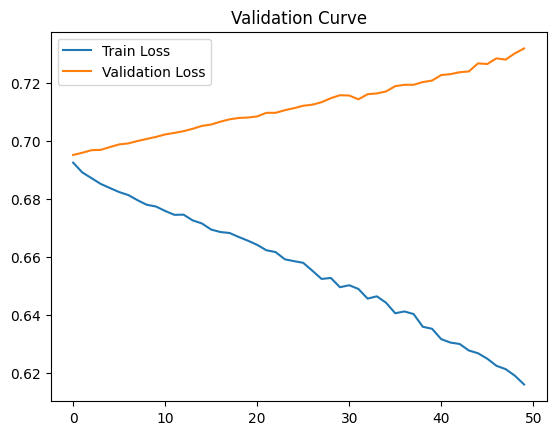

Min Loss: 0.6952822953462601


In [7]:
EPOCHS = 50
model = MyFFN(n_features=10, hidden_dim_1=64, hidden_dim_2=64, out_dim=1)
model, train_loss, val_loss = training_loop(
    model, X_train, y_train, X_val, y_val, batch_size=32, epochs=EPOCHS
)
plot_validation_curve(train_loss, val_loss)
print(f"Min Loss: {min(val_loss)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Training Loss for Epoch 50: 0.6657268881797791
Validation Loss for Epoch 50: 0.7142947316169739
Training Loss for Epoch 100: 0.6180922746658325
Validation Loss for Epoch 100: 0.7341216802597046


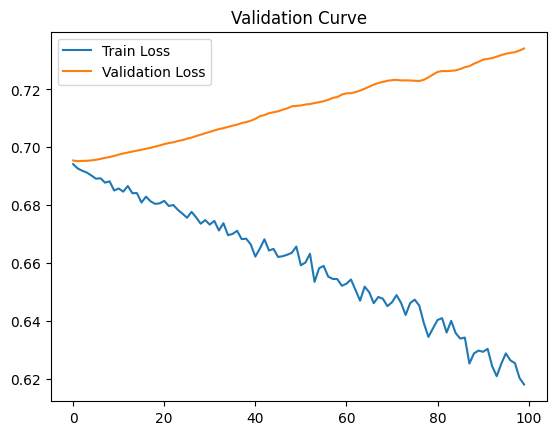

Min Loss: 0.6952072083950043


In [ ]:
EPOCHS = 100
model = MyFFN(n_features=10, hidden_dim_1=64, hidden_dim_2=64, out_dim=1)
model, train_loss, val_loss = training_loop(
    model, X_train, y_train, batch_size=128, epochs=EPOCHS
)
plot_validation_curve(train_loss, val_loss, epoch=EPOCHS)
print(f"Min Loss: {min(val_loss)}")

In [ ]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
MyFFN                                    --
├─Linear: 1-1                            704
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            65
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0

  0%|          | 0/20 [00:00<?, ?it/s]

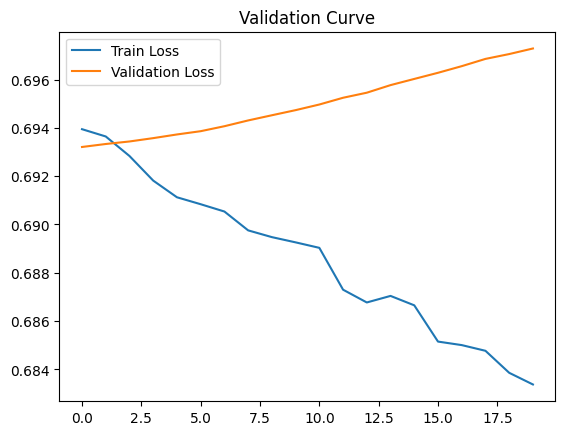

Min Loss: 0.6932080686092377


In [ ]:
EPOCHS = 20
model = MyFFN(n_features=10, hidden_dim_1=32, hidden_dim_2=32, out_dim=1)
model, train_loss, val_loss = training_loop(
    model, X_train, y_train, batch_size=64, epochs=EPOCHS
)
plot_validation_curve(train_loss, val_loss, epoch=EPOCHS)
print(f"Min Loss: {min(val_loss)}")

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
MyFFN                                    --
├─Linear: 1-1                            352
├─ReLU: 1-2                              --
├─Linear: 1-3                            1,056
├─ReLU: 1-4                              --
├─Linear: 1-5                            33
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0